In [26]:
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [27]:
mnist = fetch_openml('mnist_784', version=1, parser='auto')

In [28]:
print(mnist.DESCR) # o dataset normalmente fica em cache em $HOME/scikit_learn_data. No meu caso no windows: C:\Users\josen\scikit_learn_data

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [29]:
mnist.keys() #dict python

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [30]:
X, y = mnist.data, mnist.target
print(X.shape)
print(y.shape)
#X é um dataframe pandas, y é uma serie pandas

(70000, 784)
(70000,)


In [31]:
print(y.value_counts()) # para ver quantas amostras o dataset possui por classe

class
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64


In [ ]:
some_digit = X.loc[0,:] #X[0] - será usado mais a frente na predição
# converter de serie pandas para numpy (na verdade já vê a serie como um array)
some_digit_np = some_digit.to_numpy()
some_digit_image = some_digit_np.reshape(28,28)

<class 'pandas.core.series.Series'>


(-0.5, 27.5, 27.5, -0.5)

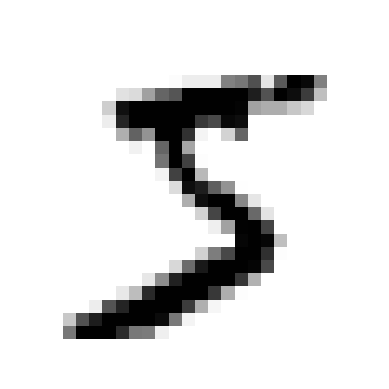

In [33]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')

In [34]:
y[0] #verifica se y[0] é o dígito 5 mesmo

'5'

In [35]:
import numpy as np
# como o label é uma string, vamos converter para número, pois os algoritmos ML trabalham com números
y = y.astype(np.uint8) # unsigned int de 1 byte, o famoso unsigned char do C

In [36]:
# o dataset MNIST já é separado em conjunto de treino e teste, onde o conjunto de treino está embaralhado (shuffle),
# o que é bom neste caso

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [37]:
print(y_test.value_counts())

class
1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: count, dtype: int64


In [38]:
# vamos exemplificar treinando um classificador binário para reconhecer apenas o número 5, portanto, classes 5 e não 5
y_train_5 = (y_train == 5) # 1(true) para o 5, 0(false) para os demais
y_test_5 = (y_test == 5)

In [39]:
"""
escolher um classificador (knn, svm, naivebayes, nn, sgd, decisiontree etc.). Vamos usar o SGD (stochastic gradient descent), um
classificador que lida bem com conjunto grande de dados e lida com instâncias de treinamento uma por vez, de forma independente, sendo
boa opção para aprendizado online. Em sua configuração padrão é um modelo linear regularizado (L2) - SVM
""" 

from sklearn.linear_model import SGDClassifier
model_sgd = SGDClassifier(random_state=42) #se quiser reproduzir os resultados
model_sgd.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [40]:
# vamos agora usar para detectar imagens com o número alvo
out = model_sgd.predict([some_digit])
print(out)

[ True]


c:\Users\vitin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


#### Validação cruzada

In [41]:
from sklearn.model_selection import cross_val_score
cross_val_score(model_sgd, X_train, y_train_5, cv=5,scoring='accuracy', n_jobs=-1)

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

##### Vamos usar o cross_val_predict para obter predições feitas em cada teste de fold na validação cruzada e usar isto para uma matriz de confusão

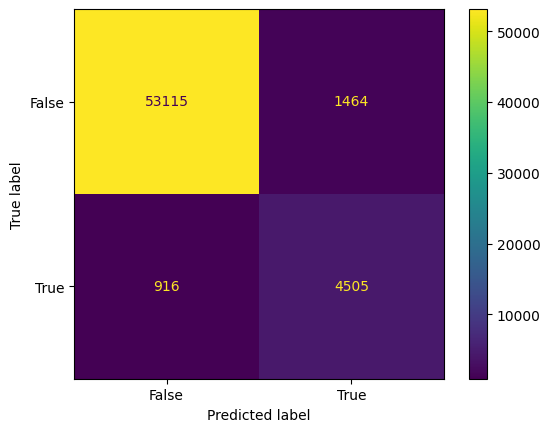

In [42]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(model_sgd, X_train, y_train_5, cv=5)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=y_train_5, y_pred=y_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_sgd.classes_)
disp.plot()

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_train_5,y_train_pred))

              precision    recall  f1-score   support

       False       0.98      0.97      0.98     54579
        True       0.75      0.83      0.79      5421

    accuracy                           0.96     60000
   macro avg       0.87      0.90      0.88     60000
weighted avg       0.96      0.96      0.96     60000



In [44]:

import pickle

with open('modelo_sgd.pkl', 'wb') as f:
    pickle.dump(model_sgd, f)

### Se quisermos fazer uma classificação binária mais equilibrada, criando amostras sintéticas da classe minoritária, para se aproximar da classe majoritária (não 5), podemos usar oversampling. Uma técnica famosa é a SMOTE

In [45]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [46]:
def my_cross_validation(model, X, y, oversampling=False):
    kfold = KFold(n_splits=10) #cv=10
    accs_split = []
    for idx, (idx_train, idx_validation) in enumerate(kfold.split(X)):
        X_split_train = X.iloc[idx_train,:]
        y_split_train = y.iloc[idx_train,:]
        # se oversampling, aplicar só no split de treino, pois o de validação precisa manter a característica de balance original
        if oversampling:
            sm = SMOTE(random_state=42)
            X_split_train, y_split_train = sm.fit_resample(X_split_train, y_split_train)
        
        model.fit(X_split_train, y_split_train.values.flatten())
        
        X_split_validation = X.iloc[idx_validation, :]
        y_split_validation = y.iloc[idx_validation, :]
        
        y_pred_validation = model.predict(X_split_validation)
        acc_split = accuracy_score(y_split_validation, y_pred_validation)
        accs_split.append(acc_split)
        
        print(f'accuracy at split {idx}: {acc_split}')
    return accs_split

Repetir os passos de instanciar o modelo, obter média de acurácia com e sem SMOTE com o cross validation da função cima. Comparar. Depois rodar o cross_validation_score do sklearn com o conjunto de treino completo com SMOTE para o reconhecedor de dígito 5 e ver que a acurácia é maior do que usando o SMOTE só na validação.